# EDA of Intel Image Classification Dataset

In this notebook I explore my dataset and ensure that the data is split up appropriately 

In [90]:
import os, shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

parent_dir = '../../'

Using TensorFlow backend.


In [37]:
# plot params:
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['savefig.directory'] = parent_dir + '/figures/'

Our data is currently split up into labeled train and test sets and then we also have access to an unlabeled 'prediction' set.  

We want to be able to validate our model without tapping into the labeled test set too early, so I'd like to further split the training set up into a validation set, which I will do now:

In [2]:
train_buildings_dir = parent_dir + 'data/seg_train/buildings'
train_forest_dir = parent_dir + 'data/seg_train/forest'
train_glacier_dir = parent_dir + 'data/seg_train/glacier'
train_mountain_dir = parent_dir + 'data/seg_train/mountain'
train_sea_dir = parent_dir + 'data/seg_train/sea'
train_street_dir = parent_dir + 'data/seg_train/street'

In [3]:
imgs_buildings = [file for file in os.listdir(train_buildings_dir) if file.endswith('.jpg')]
imgs_forest = [file for file in os.listdir(train_forest_dir) if file.endswith('.jpg')]
imgs_glacier = [file for file in os.listdir(train_glacier_dir) if file.endswith('.jpg')]
imgs_mountain = [file for file in os.listdir(train_mountain_dir) if file.endswith('.jpg')]
imgs_sea = [file for file in os.listdir(train_sea_dir) if file.endswith('.jpg')]
imgs_street = [file for file in os.listdir(train_street_dir) if file.endswith('.jpg')]

In [67]:
scenes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
img_files = [imgs_buildings, imgs_forest, imgs_glacier, imgs_mountain, imgs_sea, imgs_street]
# let's create a dictionary containing the number of images per scene
len_imgs_dict = {}
for file, scene in zip(img_files, scenes):
    print('There are', len(file), f'{scene} images')
    len_imgs_dict[scene] = len(file)

There are 2191 buildings images
There are 2271 forest images
There are 2404 glacier images
There are 2512 mountain images
There are 2274 sea images
There are 2382 street images


In [8]:
len_imgs_dict

{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

Now, let's visualise the distribution of images in the training set:

In [83]:
x = list(len_imgs_dict.keys())

In [84]:
x

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [85]:
y = list(len_imgs_dict.values())

In [86]:
y

[2191, 2271, 2404, 2512, 2274, 2382]

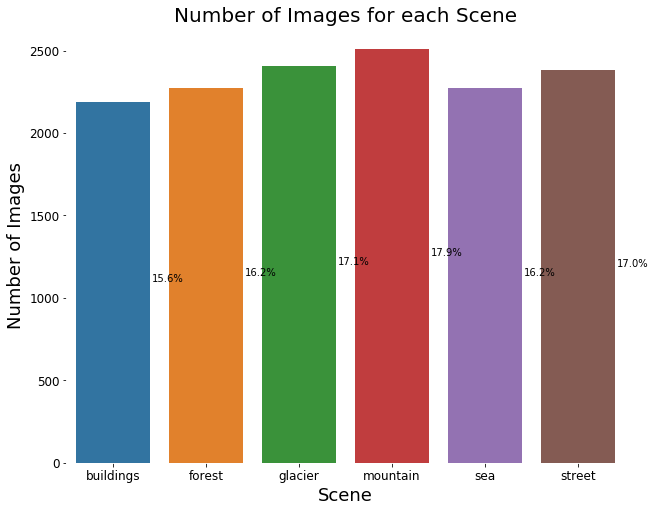

In [89]:
plt.rcParams['axes.edgecolor'] = 'white'
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(x, y)
total = np.sum(y)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x_ = p.get_x() + p.get_width() + 0.02
        y_ = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x_, y_))
plt.title('Number of Images for each Scene', fontsize = 20)
plt.xlabel('Scene', fontsize = 18)
plt.ylabel('Number of Images', fontsize = 18)
plt.xticks(fontsize = 12)
plt.savefig(parent_dir + 'figures/num_imgs_per_scene')
plt.show()

We see from this bar graph that we have relatively balanced classes with the mountain class containing the most amount of images and see containing the least.  

Now, let's get back to creating a new validation set.  We'll start by creating a validation folder:

In [104]:
val_folder = parent_dir + 'data/seg_val/'
test_folder = parent_dir + 'data/seg_test/'
train_folder = parent_dir + 'data/seg_train/'

In [105]:
test_folder

'../../data/seg_test/'

In [106]:
train_folder

'../../data/seg_train/'

In [107]:
val_folder

'../../data/seg_val/'

In [43]:
val_buildings = os.path.join(val_folder, 'buildings')
val_forest = os.path.join(val_folder, 'forest')
val_glacier = os.path.join(val_folder, 'glacier')
val_mountain = os.path.join(val_folder, 'mountain')
val_sea = os.path.join(val_folder, 'sea')
val_street = os.path.join(val_folder, 'street')

Preview one of the example file paths:

In [44]:
val_buildings

'../../data/seg_val/buildings'

Now, I'll actually create the directories:

In [46]:
os.mkdir(val_folder)
os.mkdir(val_buildings)
os.mkdir(val_forest)
os.mkdir(val_glacier)
os.mkdir(val_mountain)
os.mkdir(val_sea)
os.mkdir(val_street)

In [53]:
random.sample(imgs_buildings, 5)

['15545.jpg', '14868.jpg', '19134.jpg', '6005.jpg', '8243.jpg']

### Train Test Split

I'm now going to perform the split for the validation set.  I'm going to choose an 80-20 split to make sure we don't dilute the training set too much... 

In [60]:
# validation sets:
buildings_split_size = int(len(imgs_buildings) * 0.2)
forest_split_size = int(len(imgs_forest) * 0.2)
glacier_split_size = int(len(imgs_glacier) * 0.2)
mountain_split_size = int(len(imgs_mountain) * 0.2)
sea_split_size = int(len(imgs_sea) * 0.2)
street_split_size = int(len(imgs_street) * 0.2)

In [61]:
street_split_size

476

In [62]:
buildings_val_set = random.sample(imgs_buildings, buildings_split_size)
forest_val_set = random.sample(imgs_forest, forest_split_size)
glacier_val_set = random.sample(imgs_glacier, glacier_split_size)
mountain_val_set = random.sample(imgs_mountain, mountain_split_size)
sea_val_set = random.sample(imgs_sea, sea_split_size)
street_val_set = random.sample(imgs_street, street_split_size)

In [64]:
val_buildings

'../../data/seg_val/buildings'

In [74]:
# validation santa
val_sets = [buildings_val_set, forest_val_set, glacier_val_set, 
            mountain_val_set, sea_val_set, street_val_set]
train_locations = [train_buildings_dir, train_forest_dir, train_glacier_dir, 
                   train_mountain_dir, train_sea_dir, train_street_dir]
new_locations = [val_buildings, val_forest, val_glacier, 
               val_mountain, val_sea, val_street]
for val_set, train_location, new_location in zip(val_sets, train_locations, new_locations):
    for img in val_set:
        origin = os.path.join(train_location, img)
        destination = os.path.join(new_location, img)
        shutil.move(origin, destination)

Now let's check that the images were really moved out of the train set and into the val set.  We'll do this by recounting the number of images in the training folders:

In [73]:
train_buildings_dir

'../../data/seg_train/buildings'

In [75]:
train_imgs_buildings = [file for file in os.listdir(train_buildings_dir) if file.endswith('.jpg')]
train_imgs_forest = [file for file in os.listdir(train_forest_dir) if file.endswith('.jpg')]
train_imgs_glacier = [file for file in os.listdir(train_glacier_dir) if file.endswith('.jpg')]
train_imgs_mountain = [file for file in os.listdir(train_mountain_dir) if file.endswith('.jpg')]
train_imgs_sea = [file for file in os.listdir(train_sea_dir) if file.endswith('.jpg')]
train_imgs_street = [file for file in os.listdir(train_street_dir) if file.endswith('.jpg')]

In [76]:
scenes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train_img_files = [train_imgs_buildings, train_imgs_forest, train_imgs_glacier, 
             train_imgs_mountain, train_imgs_sea, train_imgs_street]
# let's create a dictionary containing the number of images per scene
len_train_imgs_dict = {}
for file, scene in zip(train_img_files, scenes):
    print('There are', len(file), f'{scene} images')
    len_train_imgs_dict[scene] = len(file)

There are 1753 buildings images
There are 1817 forest images
There are 1924 glacier images
There are 2010 mountain images
There are 1820 sea images
There are 1906 street images


In [77]:
len_train_imgs_dict

{'buildings': 1753,
 'forest': 1817,
 'glacier': 1924,
 'mountain': 2010,
 'sea': 1820,
 'street': 1906}

Compare with original amount in training set:

In [78]:
len_imgs_dict

{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

Now let's check the move was correct for the validation set:

In [79]:
val_imgs_buildings = [file for file in os.listdir(val_buildings) if file.endswith('.jpg')]
val_imgs_forest = [file for file in os.listdir(val_forest) if file.endswith('.jpg')]
val_imgs_glacier = [file for file in os.listdir(val_glacier) if file.endswith('.jpg')]
val_imgs_mountain = [file for file in os.listdir(val_mountain) if file.endswith('.jpg')]
val_imgs_sea = [file for file in os.listdir(val_sea) if file.endswith('.jpg')]
val_imgs_street = [file for file in os.listdir(val_street) if file.endswith('.jpg')]

scenes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
val_img_files = [val_imgs_buildings, val_imgs_forest, val_imgs_glacier, 
             val_imgs_mountain, val_imgs_sea, val_imgs_street]
# let's create a dictionary containing the number of images per scene
len_val_imgs_dict = {}
for file, scene in zip(val_img_files, scenes):
    print('There are', len(file), f'{scene} images')
    len_val_imgs_dict[scene] = len(file)

There are 438 buildings images
There are 454 forest images
There are 480 glacier images
There are 502 mountain images
There are 454 sea images
There are 476 street images


So, we now have a validation set with 20% of the training images.  We'll be able to use this for our modelling and keep our test set clean. 

Let's first see how many images we have in training, test, and validation:

In [108]:
# training
sum(list(len_train_imgs_dict.values()))

11230

In [109]:
# validation
sum(list(len_val_imgs_dict.values()))

2804

And I know there are 3000 in the test set.

At this point, I'm going to switch over to modelling and the results of this processing I will continue in the 02_modellling.ipynb notebook contained in the modelling directory. 

## Prepare for Modelling

First, we'll reshape the images in all the different datasets and create data generators for them.

In [ ]:
# test generator:
test_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(test_folder, batch_size = 64)

train_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(train_folder, batch_size = 64)


In [ ]:
# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 180) 

# get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 200)

# get all the data in the directory split/train (542 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size=542)